In [1]:
"""
Trains a Segmentalist model on a dataset and saves the resulting model checkpoints.


"""
import re
import operator
import logging
import pickle
import time
import argparse

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import tensorflow as tf
import tensorflow_addons as tfa
import kerastuner as kt
import sys
import pprint
import yaml
import uuid
import albumentations as A
import joblib 

import gim_cv.config as cfg
import gim_cv.utils as utils
import gim_cv.losses as losses
import gim_cv.datasets as datasets
import gim_cv.tools.keras_one_cycle_clr as clr

from functools import partial, reduce
from pathlib import Path
from time import perf_counter as pc

#from sklearn.externals import joblib
from tensorflow.keras.models import load_model
from distributed import Client, LocalCluster
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow_addons.optimizers import SWA
#from zarr.errors import ArrayNotFoundError

from gim_cv.models.segmentalist import Segmentalist
from gim_cv.training import TrainingDataset, pair_batch_generator, CompositeTrainingDataset, fancy_batch_generator
from gim_cv.datasets import (get_dataset,
                             get_image_training_pipeline_by_tag,
                             get_binary_mask_training_pipeline_by_tag,
                             list_datasets)
from gim_cv.preprocessing import get_aug_datagen, FancyPCA, strong_aug, balanced_oversample
from gim_cv.utils import plot_pair, parse_kwarg_str
from gim_cv.tuners import HyperbandOCP
###
import os
import time

# the model saving/loading utility functions live in the utils.py module in bin with the scripts
sys.path.append('../../bin')
from bin import utils
from PIL import Image

from contextlib import contextmanager

from numpy.lib.stride_tricks import as_strided

import math
import imageio
import numbers
import rioxarray as rx

- timbermafia has configured handlers:
  - <StreamHandler stdout (NOTSET)>
- name gim-cv given, generated named logger.


In [4]:
# TrainingDataset??

In [5]:
datasets.Dataset(tag='train_tif_2',
                            image_paths = [ '/home/root/TRAIN/raster/top_60cm_qb_area1.tif'],
                            mask_paths = ['/home/root/TRAIN/fullset/ground_truth/top_60cm_qb_area1.tif'], # say this one doesn't have any ground truth
                            spatial_resolution=0.6)

print (datasets.get_dataset('train_tif_2').image_paths)
print (datasets.get_dataset('train_tif_2').mask_paths)

[PosixPath('/home/root/TRAIN/raster/top_60cm_qb_area1.tif')]
[PosixPath('/home/root/TRAIN/fullset/ground_truth/top_60cm_qb_area1.tif')]


In [6]:
# Preparing training data

np.random.seed(cfg.seed)

# set window/patch size
patch_dims = (256, 256)

# process necessary parser arguments
layer_blocks_ = [int(n) for n in '2,2,2,2'.split(',')]
residual_filters_ = [int(n) for n in '128,256,512,1024'.split(',')]
initial_kernel_size_ = (7, 7)
head_kernel_size_ = (1, 1)

# decide partitioning into train/validation
train_val_test_split = (0.7, 0.3)

# --- assemble training datasets
# get dataset tags - sort to fix order to identify different permutations for array caching
dataset_tags = sorted(['train_tif_2'])
# get each of the training datasets requested
tdsets = []
for ds_tag in ['train_tif_2']:
    ds = datasets.get_dataset(ds_tag)
    ds.spatial_resolution = 0.6 # Mohammed added this line
    rf = ds.spatial_resolution/0.6 # Mohammed modified from 0.4 to 0.5
    tdsets.append(ds.load_training_data(batch_size=4, train_val_test_split=train_val_test_split, seed=cfg.seed, window_size=256, overlap_tiles=True, resample_factor=rf))
# combine them into one big (composite) training dataset
if len(tdsets) == 1:
    tds = tdsets[0]
else:
    tds = reduce(operator.add, tdsets)
# create a string to identify the combination of datasets and the spatial resolution
# used in saving model checkpoints to quickly identify training data used
data_res_str = f"data_{tds.tags_str}_target_res_{0.6}"
data_res_str += '_overlapping_tiles'
# set the cache directory to save preprocessed arrays in an appropriately named directory
tds.cache_directory = cfg.proc_data_path / Path(data_res_str)

In [7]:
# --- preprocess training data
# generate arrays from rasters on-the-fly at training time
tds.prepare()
# print(type(tds))

19:27:58  I  …iteTrainingDataset.prune  Selecting training datasets to eliminate with               
                                        has_empty_raster...                                         
19:27:58  D  …iningDataset.load_arrays  loading arrays                                              
19:27:58  D  …iningDataset.load_arrays  done loading arrays                                         
19:27:58  I  …iteTrainingDataset.prune  Removed 0 TrainingDatasets, leaving 1.                      
19:27:58  D    TrainingDataset.prepare  Obtaining arrays for                                        
                                        /home/root/TRAIN/raster/top_60cm_qb_area1.tif, /home/root/TR
                                        AIN/fullset/ground_truth/top_60cm_qb_area1.tif...           
19:27:58  D  …iningDataset.load_arrays  loading arrays                                              
19:27:58  D  …iningDataset.load_arrays  done loading arrays                                

19:27:58  D      TileStacker.transform  Reshaping array into tiles...                               
19:27:58  D  …erlappingTiler.transform  Assembling overlapping tiles...                             
19:27:58  I    TrainingDataset.prepare  Image pipeline done!                                        
19:27:58  D   DimensionAdder.transform  Leaving array shape alone...                                
19:27:58  D       OverlappingTiler.fit  Dividing array with shape (2001, 2001, 1) into half-step    
                                        overlapping tiles...                                        
19:27:58  D                  Tiler.fit  Shape going into stacker: (2001, 2001, 1)                   
19:27:58  D     WindowFitter.transform  Transforming input data to match integer number of          
                                        windows...                                                  
19:27:58  D     WindowFitter.transform  Transforming input data to match integer number of 

19:28:00  I  …eTrainingDataset.prepare  Shuffling datasets together...                              
19:28:00  I  …eTrainingDataset.prepare  Composite dataset prepare done!                             


In [8]:
log = logging.getLogger()
# --- assign data generator for scaling, augmentations etc
# albumentations + fancyPCA => "fancy" augs. recommended.
if True:
    log.warning("~~ Fancy augs on ~~")
    # start distributed cluster for mapping augmentations
    client = Client(processes=False)
    log.info("Calculating PCA decomposition of training RGBs...")
    fpca = FancyPCA(tds.X_train, alpha_std=.3, p=1.0)
    log.warning(f"Eigenvalues are {fpca.sampler.eig_vals}")
    log.warning(f"Eigenvectors are {fpca.sampler.eig_vecs}")
    augger = strong_aug(p=.8, fancy_pca=fpca)
    tds.batch_generator_fn = partial(fancy_batch_generator, batch_size=4, augger=augger, client=client, seed=cfg.seed, shuffle_blocks_every_epoch=True, shuffle_within_blocks=True, deep_supervision=True, float32=True)
    aug_sfx = 'fancy'

~~ Fancy augs on ~~
Eigenvalues are [0.06179941 0.0035789  0.00054771]
Eigenvectors are [[-0.54852031 -0.58008069 -0.60218923]
 [-0.58416047 -0.24942219  0.77236333]
 [-0.59823241  0.77543212 -0.20204707]]


In [9]:
x = tds.get_X()
print(x.shape)
y = tds.get_y()
print(y.shape)
# print(dir(tds))
print("X train:", tds.X_train.shape)
print("X Val:", tds.X_val.shape)

(256, 256, 256, 3)
(256, 256, 256, 1)
X train: (179, 256, 256, 3)
X Val: (77, 256, 256, 3)


In [12]:
log = logging.getLogger()
if True:
    # 
    assert tf.test.is_gpu_available(), "CHECK GPU AVAILABILITY! (eg /etc/docker/daemon.json default runtime)"
    #
    ## --- configure model training
    # get loss function and any kwargs (entered as a string to argparser)
    loss_fn_name, *lf_kwarg_str = 'dice_coeff_loss'.split(':')
    # grab func itself from losses module by name
    loss_fn = getattr(losses, loss_fn_name)
    # optionally provide kwargs to higher-order function to return lf
    if lf_kwarg_str:
        lf_kwargs = parse_kwarg_str(*lf_kwarg_str)
        loss_fn = loss_fn(**lf_kwargs)
    else:
        lf_kwargs = {}
    # encode loss function args as a cleaned-up string for identifying models trained with this
    lfastr = '_args_' + '_'.join([f'{k}={v:.2f}' for k, v in lf_kwargs.items()]) if lf_kwargs else ''
    # calculate number of training and validation steps
    train_steps = tds.X_train.shape[0]//4
    valid_steps = tds.X_val.shape[0]//4
    print(f'train_steps={train_steps}')
    print(f'val_steps={valid_steps}')
    if True:
        assert tds.X_val.shape[0] > 0, (
            "Not enough dask blocks to make up validation data frac!\n"
            f"train: {tds.X_train}"
        )
    # select metrics
    metrics = [losses.tversky_index, losses.jaccard_index, losses.recall, losses.precision, losses.specificity, losses.npv, losses.dice_coefficient]
    # interpret optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) # check out RADAM?
    # stoachastic weight averaging if enabled
    opt = SWA(opt, start_averaging=100 - 50, average_period=5)
    # specify training directory to save weights and metrics for this loss_fn and data ID
    project_name = Path(f'Segmentalist_{uuid.uuid4()}')
    training_dir = Path(str(cfg.models_path)) / project_name
    training_dir.mkdir(parents=True, exist_ok=True)
    # -- callbacks
    # early stopping
    monitor = 'loss'
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor, patience=7)]
    # reduce the learning rate on plateaus
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,factor=0.5,patience=2, min_lr=0.000001))
    # set up tensorboard to record metrics in a subdirectory
    tb_pth = training_dir / Path("metrics/")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir=str(tb_pth),update_freq=50)
    callbacks.append(tb_cb)
    # set up checkpoints in the training directory
#     cp_fmt = 'cp-e{epoch:02d}-ji{jaccard_index:.5f}-l{loss:.5f}'
#     suffix = '-vl{val_loss:.5f}.ckpt'
#     cp_fmt = cp_fmt + '-vl0.00.ckpt' # suffix
    cp_fmt = 'cp-e{epoch:02d}-ji{jaccard_index:.5f}-l{loss:.5f}'
    suffix = '-vl{val_loss:.5f}.ckpt'
    cp_fmt = cp_fmt + '-vl0.00.ckpt' # suffix
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(training_dir / Path(cp_fmt)), monitor=monitor, save_best_only=True, save_weights_only=True, verbose=1)
    cp_callback_trn = tf.keras.callbacks.ModelCheckpoint(filepath=str(training_dir / Path(cp_fmt)), monitor='loss', save_best_only=True, save_weights_only=True, verbose=1)
    # callbacks.append(cp_callback)
    callbacks.append(cp_callback_trn)
    # --- build and compile the model
    # format attention gate param
    ag = 'SAG'
    model = Segmentalist(n_classes=tds.y_train.shape[-1], layer_blocks=[2,2,2,2], last_decoder_layer_blocks=2, initial_filters=64, residual_filters=[128,256,512,1024],
        initial_kernel_size=(7, 7), head_kernel_size=(1, 1), cardinality=1, act='relu', downsample='pool',
        decoder_attention_gates=ag, encoder_cbam=True, decoder_cbam=True, pyramid_pooling=True, deep_supervision=True, lambda_conv=True,)
    model.build(input_shape=(4, 256, 256, tds.X_train.shape[-1]))
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    
        # option to dump test data removed for testing session
    # dump setup
    # augmentations
    A.save(augger, f'{training_dir}/transform.yml', data_format='yaml')
    # 
    log.info("Start training...")
    # 
    args = {'datasets': 'train_tif_2', 'target_spatial_resolution': 0.6, 'pyramid_pooling': True, 'deep_supervision': True, 'lambda_conv': True, 'encoder_cbam': True, 'decoder_cbam': True, 'sag': True, 'csag': True, 'layer_blocks': '2,2,2,2', 'layer_blocks_' : [2,2,2,2], 'last_decoder_layer_blocks': 2, 'initial_filters': 64, 'residual_filters': '128,256,512,1024', 'residual_filters_' : [128,256,512,1024], 'initial_kernel_size': 7, 'initial_kernel_size_' : (7, 7), 'head_kernel_size': 1, 'head_kernel_size_' : (1, 1), 'cardinality': 1, 'activation': 'relu', 'downsample': 'pool', 'patch_size': 256, 'overlapping_tiles': True, 'epochs': 100, 'batch_size': 4, 'loss_fn': 'dice_coeff_loss', 'optimiser': 'adam', 'swa': True, 'duration_swa': 50, 'period_swa': 5, 'use_val': False, 'patience': 7, 'seed': 42, 'val_frac': 0.1, 'test_frac': 0.0, 'fancy_augs': True, 'lr_init': 0.0001, 'lr_min': 1e-06, 'lr_reduce_factor': 0.5, 'lr_reduce_patience': 2, 'ocp': False, 'balanced_oversample': False, 'models_dir': str(cfg.models_path), 'dump_test_data': False, 'dump_first_batches': False, 'use_cache': False, 'save_to_cache': False}
    # 
    with open(f'{training_dir}/run_params.yml', 'w') as outfile:
        yaml.dump(args, outfile, default_flow_style=False)
    
    # --- train the model
    print('fit model')
    model.fit(tds.batch_gen_train(), steps_per_epoch=train_steps, epochs=2, max_queue_size=50, callbacks=callbacks, 
              validation_data=tds.batch_gen_val(), validation_steps=valid_steps)

train_steps=44
val_steps=19
fit model


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


Epoch 1/2


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)



 1/44 [..............................] - ETA: 0s - loss: 0.1058 - tversky_index: 0.8006 - jaccard_index: 0.8086 - recall: 0.6846 - precision: 1.0000 - specificity: 1.0000 - npv: 1.2096e-05 - dice_coefficient: 0.8942

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


 6/44 [===>..........................] - ETA: 1:47 - loss: -0.0385 - tversky_index: 0.9336 - jaccard_index: 1.0912 - recall: 0.8121 - precision: 1.0000 - specificity: 1.0000 - npv: 2.4005e-05 - dice_coefficient: 1.0385

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


11/44 [======>.......................] - ETA: 1:23 - loss: -0.1202 - tversky_index: 1.0067 - jaccard_index: 1.3134 - recall: 0.8752 - precision: 1.0000 - specificity: 0.9301 - npv: 1.2078e-04 - dice_coefficient: 1.1202

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


16/44 [=========>....................] - ETA: 1:08 - loss: -0.1438 - tversky_index: 1.0365 - jaccard_index: 1.3690 - recall: 0.9098 - precision: 1.0000 - specificity: 0.9520 - npv: 1.7156e-04 - dice_coefficient: 1.1438

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


20/44 [============>.................] - ETA: 57s - loss: -0.1515 - tversky_index: 1.0490 - jaccard_index: 1.3877 - recall: 0.9268 - precision: 1.0000 - specificity: 0.9616 - npv: 2.8273e-04 - dice_coefficient: 1.1515 

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


25/44 [================>.............] - ETA: 44s - loss: -0.1550 - tversky_index: 1.0574 - jaccard_index: 1.3975 - recall: 0.9406 - precision: 1.0000 - specificity: 0.9693 - npv: 4.2272e-04 - dice_coefficient: 1.1550

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


30/44 [===================>..........] - ETA: 32s - loss: -0.1649 - tversky_index: 1.0673 - jaccard_index: 1.4246 - recall: 0.9502 - precision: 1.0000 - specificity: 0.9744 - npv: 6.7402e-04 - dice_coefficient: 1.1649

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


35/44 [======================>.......] - ETA: 20s - loss: -0.1705 - tversky_index: 1.0737 - jaccard_index: 1.4392 - recall: 0.9571 - precision: 1.0000 - specificity: 0.9498 - npv: 0.0010 - dice_coefficient: 1.1705    

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


40/44 [==========================>...] - ETA: 9s - loss: -0.1665 - tversky_index: 1.0740 - jaccard_index: 1.4290 - recall: 0.9623 - precision: 1.0000 - specificity: 0.9561 - npv: 0.0014 - dice_coefficient: 1.1665 

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


43/44 [============================>.] - ETA: 2s - loss: -0.1705 - tversky_index: 1.0774 - jaccard_index: 1.4397 - recall: 0.9649 - precision: 1.0000 - specificity: 0.9591 - npv: 0.0016 - dice_coefficient: 1.1705

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)



44/44 [==============================] - ETA: 0s - loss: -0.1700 - tversky_index: 1.0775 - jaccard_index: 1.4376 - recall: 0.9657 - precision: 1.0000 - specificity: 0.9601 - npv: 0.0016 - dice_coefficient: 1.1700

distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)



Epoch 00001: loss improved from inf to -0.17000, saving model to /home/root/saved_models/Segmentalist_fe08070b-16d8-4a4d-86ec-2e159e4e0fb6/cp-e01-ji1.43762-l-0.17000-vl0.00.ckpt
44/44 [==============================] - 134s 3s/step - loss: -0.1700 - tversky_index: 1.0775 - jaccard_index: 1.4376 - recall: 0.9657 - precision: 1.0000 - specificity: 0.9601 - npv: 0.0016 - dice_coefficient: 1.1700 - val_loss: -0.0052 - val_tversky_index: 0.8847 - val_jaccard_index: 1.0139 - val_recall: 0.7505 - val_precision: 0.9999 - val_specificity: 0.8828 - val_npv: 8.3266e-05 - val_dice_coefficient: 1.0052 - lr: 1.0000e-04
Epoch 2/2
 4/44 [=>............................] - ETA: 1:06 - loss: -0.1955 - tversky_index: 1.1078 - jaccard_index: 1.4986 - recall: 0.9993 - precision: 1.0000 - specificity: 1.0000 - npv: 0.0054 - dice_coefficient: 1.1955

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


 9/44 [=====>........................] - ETA: 1:08 - loss: -0.2027 - tversky_index: 1.1110 - jaccard_index: 1.5316 - recall: 0.9992 - precision: 1.0000 - specificity: 1.0000 - npv: 0.0054 - dice_coefficient: 1.2027

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


14/44 [========>.....................] - ETA: 1:01 - loss: -0.2144 - tversky_index: 1.1172 - jaccard_index: 1.5664 - recall: 0.9992 - precision: 1.0000 - specificity: 1.0000 - npv: 0.0055 - dice_coefficient: 1.2144

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


18/44 [===========>..................] - ETA: 54s - loss: -0.2023 - tversky_index: 1.1111 - jaccard_index: 1.5264 - recall: 0.9993 - precision: 1.0000 - specificity: 0.9452 - npv: 0.0058 - dice_coefficient: 1.2023

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


24/44 [===============>..............] - ETA: 42s - loss: -0.1976 - tversky_index: 1.1085 - jaccard_index: 1.5147 - recall: 0.9993 - precision: 1.0000 - specificity: 0.9589 - npv: 0.0064 - dice_coefficient: 1.1976

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


28/44 [==================>...........] - ETA: 34s - loss: -0.2001 - tversky_index: 1.1098 - jaccard_index: 1.5215 - recall: 0.9994 - precision: 1.0000 - specificity: 0.9648 - npv: 0.0068 - dice_coefficient: 1.2001

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


34/44 [======================>.......] - ETA: 21s - loss: -0.2023 - tversky_index: 1.1110 - jaccard_index: 1.5272 - recall: 0.9994 - precision: 1.0000 - specificity: 0.9418 - npv: 0.0071 - dice_coefficient: 1.2023

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


39/44 [=========================>....] - ETA: 10s - loss: -0.1945 - tversky_index: 1.1067 - jaccard_index: 1.5067 - recall: 0.9994 - precision: 1.0000 - specificity: 0.9492 - npv: 0.0076 - dice_coefficient: 1.1945

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


43/44 [============================>.] - ETA: 2s - loss: -0.1967 - tversky_index: 1.1080 - jaccard_index: 1.5118 - recall: 0.9995 - precision: 1.0000 - specificity: 0.9540 - npv: 0.0078 - dice_coefficient: 1.1967

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)



44/44 [==============================] - ETA: 0s - loss: -0.1956 - tversky_index: 1.1074 - jaccard_index: 1.5082 - recall: 0.9995 - precision: 1.0000 - specificity: 0.9550 - npv: 0.0079 - dice_coefficient: 1.1956

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)



Epoch 00002: loss improved from -0.17000 to -0.19559, saving model to /home/root/saved_models/Segmentalist_fe08070b-16d8-4a4d-86ec-2e159e4e0fb6/cp-e02-ji1.50817-l-0.19559-vl0.00.ckpt
44/44 [==============================] - 118s 3s/step - loss: -0.1956 - tversky_index: 1.1074 - jaccard_index: 1.5082 - recall: 0.9995 - precision: 1.0000 - specificity: 0.9550 - npv: 0.0079 - dice_coefficient: 1.1956 - val_loss: -0.1364 - val_tversky_index: 1.0328 - val_jaccard_index: 1.3227 - val_recall: 0.9093 - val_precision: 1.0000 - val_specificity: 1.0000 - val_npv: 4.2045e-05 - val_dice_coefficient: 1.1364 - lr: 1.0000e-04


In [18]:
# Define datasets on disk
ds1 = datasets.Dataset(tag='train_tif',
                            image_paths = ['/home/root/tests/resources/train_data_tif/rasters/Medellin_40cm.tif'],
                            mask_paths = ['/home/root/tests/resources/train_data_tif/masks/Medellin_ground_truth.tif'], # say this one doesn't have any ground truth
                            spatial_resolution=0.4)

In [44]:
log = logging.getLogger()
if True:
    # 
    assert tf.test.is_gpu_available(), "CHECK GPU AVAILABILITY! (eg /etc/docker/daemon.json default runtime)"
    #
    np.random.seed(cfg.seed)
    # set window/patch size
    patch_dims = (256, 256)
    # process necessary parser arguments
    layer_blocks_ = [int(n) for n in '2,2,2,2'.split(',')]
    residual_filters_ = [int(n) for n in '128,256,512,1024'.split(',')]
    initial_kernel_size_ = (7, 7)
    head_kernel_size_ = (1, 1)
    # decide partitioning into train/validation
    train_val_test_split = (1.-0.4, 0.4)
    # --- assemble training datasets
    # get dataset tags - sort to fix order to identify different permutations for array caching
    dataset_tags = sorted(['train_tif'])
    # get each of the training datasets requested
    tdsets = []
    for ds_tag in ['train_tif']:
        ds = datasets.get_dataset(ds_tag)
        rf = ds.spatial_resolution/0.4
        tdsets.append(ds.load_training_data(batch_size=4, train_val_test_split=train_val_test_split, seed=cfg.seed, window_size=256, overlap_tiles=True, resample_factor=rf))
    # combine them into one big (composite) training dataset
    if len(tdsets) == 1:
        tds = tdsets[0]
    else:
        tds = reduce(operator.add, tdsets)
    # create a string to identify the combination of datasets and the spatial resolution
    # used in saving model checkpoints to quickly identify training data used
    data_res_str = f"data_{tds.tags_str}_target_res_{0.4}"
    data_res_str += '_overlapping_tiles'
    # set the cache directory to save preprocessed arrays in an appropriately named directory
    tds.cache_directory = cfg.proc_data_path / Path(data_res_str)
    # --- preprocess training data
    # generate arrays from rasters on-the-fly at training time
    tds.prepare()
    # skipped              
    # --- assign data generator for scaling, augmentations etc
    # albumentations + fancyPCA => "fancy" augs. recommended.
#     if True:
#         log.warning("~~ Fancy augs on ~~")
#         # start distributed cluster for mapping augmentations
#         client = Client(processes=False)
#         log.info("Calculating PCA decomposition of training RGBs...")
#         fpca = FancyPCA(tds.X_train, alpha_std=.3, p=1.0)
#         log.warning(f"Eigenvalues are {fpca.sampler.eig_vals}")
#         log.warning(f"Eigenvectors are {fpca.sampler.eig_vecs}")
#         augger = strong_aug(p=.8, fancy_pca=fpca)
#         tds.batch_generator_fn = partial(fancy_batch_generator, batch_size=4, augger=augger, client=client, seed=cfg.seed, shuffle_blocks_every_epoch=True, shuffle_within_blocks=True, deep_supervision=True, float32=True)
#         aug_sfx = 'fancy'
    ## --- configure model training
    # get loss function and any kwargs (entered as a string to argparser)
    loss_fn_name, *lf_kwarg_str = 'dice_coeff_loss'.split(':')
    # grab func itself from losses module by name
    loss_fn = getattr(losses, loss_fn_name)
    # optionally provide kwargs to higher-order function to return lf
    if lf_kwarg_str:
        lf_kwargs = parse_kwarg_str(*lf_kwarg_str)
        loss_fn = loss_fn(**lf_kwargs)
    else:
        lf_kwargs = {}
    # encode loss function args as a cleaned-up string for identifying models trained with this
    lfastr = '_args_' + '_'.join([f'{k}={v:.2f}' for k, v in lf_kwargs.items()]) if lf_kwargs else ''
    # calculate number of training and validation steps
    train_steps = tds.X_train.shape[0]//4
    valid_steps = tds.X_val.shape[0]//4
    print(f'train_steps={train_steps}')
    print(f'val_steps={valid_steps}')
    if True:
        assert tds.X_val.shape[0] > 0, (
            "Not enough dask blocks to make up validation data frac!\n"
            f"train: {tds.X_train}"
        )
    # select metrics
    metrics = [losses.tversky_index, losses.jaccard_index, losses.recall, losses.precision, losses.specificity, losses.npv, losses.dice_coefficient]
    # interpret optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False) # check out RADAM?
    # stoachastic weight averaging if enabled
    opt = SWA(opt, start_averaging=100 - 50, average_period=5)
    # specify training directory to save weights and metrics for this loss_fn and data ID
    project_name = Path(f'Segmentalist_{uuid.uuid4()}')
    training_dir = Path(str(cfg.models_path)) / project_name
    training_dir.mkdir(parents=True, exist_ok=True)
    # -- callbacks
    # early stopping
    monitor = 'loss'
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor, patience=7)]
    # reduce the learning rate on plateaus
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,factor=0.5,patience=2, min_lr=0.000001))
    # set up tensorboard to record metrics in a subdirectory
    tb_pth = training_dir / Path("metrics/")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir=str(tb_pth),update_freq=50)
    callbacks.append(tb_cb)
    # set up checkpoints in the training directory
    cp_fmt = 'cp-e{epoch:02d}-ji{jaccard_index:.5f}-l{loss:.5f}'
    suffix = '-vl{val_loss:.5f}.ckpt'
    cp_fmt = cp_fmt + '-vl0.00.ckpt' # suffix
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(training_dir / Path(cp_fmt)), monitor=monitor, save_best_only=True, save_weights_only=True, verbose=1)
    cp_callback_trn = tf.keras.callbacks.ModelCheckpoint(filepath=str(training_dir / Path(cp_fmt)), monitor='loss', save_best_only=True, save_weights_only=True, verbose=1)
    # callbacks.append(cp_callback)
    callbacks.append(cp_callback_trn)
    # --- build and compile the model
    # format attention gate param
    ag = 'SAG'
    model = Segmentalist(n_classes=tds.y_train.shape[-1], layer_blocks=[2,2,2,2], last_decoder_layer_blocks=2, initial_filters=64, residual_filters=[128,256,512,1024],
        initial_kernel_size=(7, 7), head_kernel_size=(1, 1), cardinality=1, act='relu', downsample='pool',
        decoder_attention_gates=ag, encoder_cbam=True, decoder_cbam=True, pyramid_pooling=True, deep_supervision=True, lambda_conv=True,)
    model.build(input_shape=(4, 256, 256, tds.X_train.shape[-1]))
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    # option to dump test data removed for testing session
    # dump setup
    # augmentations
    A.save(augger, f'{training_dir}/transform.yml', data_format='yaml')
    # 
    log.info("Start training...")
    # 
    args = {'datasets': 'train_tif', 'target_spatial_resolution': 0.4, 'pyramid_pooling': True, 'deep_supervision': True, 'lambda_conv': True, 'encoder_cbam': True, 'decoder_cbam': True, 'sag': True, 'csag': True, 'layer_blocks': '2,2,2,2', 'layer_blocks_' : [2,2,2,2], 'last_decoder_layer_blocks': 2, 'initial_filters': 64, 'residual_filters': '128,256,512,1024', 'residual_filters_' : [128,256,512,1024], 'initial_kernel_size': 7, 'initial_kernel_size_' : (7, 7), 'head_kernel_size': 1, 'head_kernel_size_' : (1, 1), 'cardinality': 1, 'activation': 'relu', 'downsample': 'pool', 'patch_size': 256, 'overlapping_tiles': True, 'epochs': 100, 'batch_size': 4, 'loss_fn': 'dice_coeff_loss', 'optimiser': 'adam', 'swa': True, 'duration_swa': 50, 'period_swa': 5, 'use_val': False, 'patience': 7, 'seed': 42, 'val_frac': 0.1, 'test_frac': 0.0, 'fancy_augs': True, 'lr_init': 0.0001, 'lr_min': 1e-06, 'lr_reduce_factor': 0.5, 'lr_reduce_patience': 2, 'ocp': False, 'balanced_oversample': False, 'models_dir': str(cfg.models_path), 'dump_test_data': False, 'dump_first_batches': False, 'use_cache': False, 'save_to_cache': False}
    # 
    with open(f'{training_dir}/run_params.yml', 'w') as outfile:
        yaml.dump(args, outfile, default_flow_style=False)
    # --- train the model
    print('fit model')
    model.fit(tds.batch_gen_train(), steps_per_epoch=train_steps, epochs=100, max_queue_size=50, callbacks=callbacks, 
              validation_data=tds.batch_gen_val(), validation_steps=valid_steps)
    # validation_data=tds.batch_gen_val(), validation_steps=valid_steps,


23:43:47  I  …iteTrainingDataset.prune  Selecting training datasets to eliminate with               
                                        has_empty_raster...                                         
23:43:47  D  …iningDataset.load_arrays  loading arrays                                              
23:43:47  D  …iningDataset.load_arrays  done loading arrays                                         
23:43:48  I  …iteTrainingDataset.prune  Removed 0 TrainingDatasets, leaving 1.                      
23:43:48  D    TrainingDataset.prepare  Obtaining arrays for /home/root/tests/resources/train_data_t
                                        if/rasters/Medellin_40cm.tif, /home/root/tests/resources/tra
                                        in_data_tif/masks/Medellin_ground_truth.tif...              
23:43:48  D  …iningDataset.load_arrays  loading arrays                                              
23:43:48  D  …iningDataset.load_arrays  done loading arrays                                

23:43:48  D  …erlappingTiler.transform  Assembling overlapping tiles...                             
23:43:48  I    TrainingDataset.prepare  Image pipeline done!                                        
23:43:48  D   DimensionAdder.transform  Leaving array shape alone...                                
23:43:48  D       OverlappingTiler.fit  Dividing array with shape (2519, 3579, 1) into half-step    
                                        overlapping tiles...                                        
23:43:48  D                  Tiler.fit  Shape going into stacker: (2519, 3579, 1)                   
23:43:48  D     WindowFitter.transform  Transforming input data to match integer number of          
                                        windows...                                                  
23:43:48  D     WindowFitter.transform  Transforming input data to match integer number of          
                                        windows...                                         

23:43:49  I  …eTrainingDataset.prepare  Composite dataset prepare done!                             
train_steps=84
val_steps=56
fit model


TypeError: 'NoneType' object is not callable

In [23]:
df_segm_trained = utils.collate_run_data(Path(str(cfg.models_path)), model_name='Segmentalist')

df_segm_trained = df_segm_trained.drop(['seed', 'save_to_cache'] + [c for c in df_segm_trained.columns if any(i in c for i in ('_train',  'ocp', 'fancy_augs', 'dump_test_data', 'dump_first_batches', 'channel_expansion_factor'))], axis=1).sort_values(by='lowest_loss')
# we can select a sub
view_cols = ['datasets', 'lowest_loss', 'balanced_oversample', 'batch_size', 'patch_size', 'overlapping_tiles', 'deep_supervision', 'target_spatial_resolution', 'pyramid_pooling', 'loss_fn', 'val_frac']
# 
df_segm_trained[view_cols + ['uuid4'] ] # 
row = df_segm_trained.query('datasets == "train_tif"').iloc[0]
# row
inference_window_size = 1024
# load again with new patch shape
model = Segmentalist.load_from_metadata(row=row)
# shouldn't have to run these lines, LRM will look at the method above and fix so weight loading is included properly...
# workaround which fixes weight loading; "prime" model on something of the right shape
model(np.random.rand(1, inference_window_size, inference_window_size, 3))
model.load_weights(row.lowest_loss_ckpt) # takes a wee minute
model.stop_training = True


/home/root/saved_models/Segmentalist_fe08070b-16d8-4a4d-86ec-2e159e4e0fb6 failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_524faef9-1cdf-4f4d-a307-1314faf0cf43 failed with exception:
'NoneType' object has no attribute 'group'

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [36]:
def extract_patches(arr, patch_shape=(512,512,3), extraction_step=512):
    arr_ndim = arr.ndim

    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = arr[slices].strides

    patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)
    return patches

-----------------------------------------------------------
Running prediction on image:   top_60cm_qb_area1.tif
(3, 3, 1, 512, 512, 3)
((23, 24), (23, 24), (0, 0))
Confirm new padded image size : (2048, 2048, 3)
(4, 4, 1, 512, 512, 3)
(16, 512, 512, 3)


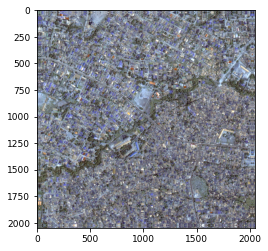

EinopsError:  Error while processing rearrange-reduction pattern "b u (hh ww) v -> b v hh ww u".
 Input tensor shape: (1, 1, 65536, 32). Additional info: {'hh': 512, 'ww': 512}.
 Shape mismatch, 65536 != 262144

In [43]:
# path_to_dir = str(cfg.infer_data_tif_path) # '/home/root/tests/resources/infer_data_tif' # infer_data_tif

path_to_dir = '/home/root/TRAIN/raster/'
image_name = 'top_60cm_qb_area1.tif'
# for image_name in tif_files:
print('-----------------------------------------------------------')
print("Running prediction on image:  ", image_name)
# specify the repository where the input file is located and its name
# path_to_dir = '/home/root/data/volumes/datasets/baranquilla_full_40cm/' # baranquilla_merged_33_resampled_40cm
path_to_file_complete = os.path.join(path_to_dir, image_name)
# print("----------------------------------------------------------------------------------------------------")
# print(path_to_file_complete)
img = imageio.imread(path_to_file_complete)
plt.imshow(img)
patches = extract_patches(img)
print(patches.shape)
# print(patches.reshape((-1, 1024, 1024, 3)).shape)
image_size = img.shape
# print("image size :", image_size)
input_patch_size = (512, 512, 3)
padded_image_size = [math.ceil(image_size[i]/input_patch_size[i]) * (input_patch_size[i]) for i in range(3)]
# print("padded image size :", padded_image_size)
topad = []
for i in range(len(image_size)-1):
    if (padded_image_size[i] - image_size[i])%2 == 0:
        topad.append((int((padded_image_size[i]- image_size[i])/2), int((padded_image_size[i]- image_size[i])/2)))
    else:
        topad.append((int((padded_image_size[i]- image_size[i])//2), int((padded_image_size[i]- image_size[i])//2)+1))
topad.append((0,0))
print(tuple(topad))
###
ret = np.pad(img, pad_width=tuple(topad), mode='reflect')
print("Confirm new padded image size :", ret.shape)
###
# proceed to extract overlapping patches
ret_patches = extract_patches(ret, patch_shape=(512,512,3), extraction_step=512)
print(ret_patches.shape)
X = np.transpose(patches.reshape((-1, 32, 32, 3)), (0, 3, 1, 2))
print(ret_patches.reshape((-1, 512, 512, 3)).shape)
plt.imshow(ret)
plt.show()
# # Extra padding step to account for patch overlap during prediction process
# aug_img = np.pad(ret, pad_width=((256, 256), (256, 256), (0, 0)), mode='reflect')
# print("Check newly padded (augmented) image size :", aug_img.shape)
# # plot augmented image
# plt.imshow(aug_img)
# plt.show()
# proceed to extract overlapping patches
aug_patches = extract_patches(ret, patch_shape=(512,512,3), extraction_step=512)
topredict = aug_patches.reshape((-1, 512, 512, 3))
pred_aug_patches = []
for i in range(aug_patches.reshape((-1, 1024, 1024, 3)).shape[0]):
    pred_aug_patches.append(model(topredict[i,:,:,:][None, ...]/255.))
pred_aug_patchex = np.array(np.squeeze(pred_aug_patches))
(I,J,K) =  (ret.shape[0]//512, ret.shape[1]//512, 3)
reconst_img = np.empty((ret.shape[0],ret.shape[1]), float)
index = 0
for i in range(I):
    print('j : ', j)
    for j in range(J):
        print('i : ', i)
        reconst_img[512*i:512*(i+1), 512*j:512*(j+1)] = pred_aug_patchex[index,256:1024-256,256:1024-256] # aug_patches.reshape((-1, 640, 640, 3))[index,64:640-64,64:640-64,:]
        index += 1
    #
#
# print()
print(reconst_img.shape)
plt.imshow(reconst_img)
plt.show()
reconst_img_origin = reconst_img[topad[0][0]:reconst_img.shape[0]-topad[0][1],topad[1][0]:reconst_img.shape[1]-topad[1][1]]
###
np.save('predImg_output_xyz.npy', reconst_img_origin)
###
datenow = time.strftime("%Y%m%d-%H%M%S")
# output_name = "Model_Segmentalist_infer_" + image_name + "_" + datenow + ".tif" # 'predictedImgOutput.tif'
# output_path = cfg.predictions_data_tif_path / Path(output_name)
# #     with rasterio.open(path_to_file_complete) as src:
# #         profile = src.profile
# #         profile.update(count=1)
# #         with rasterio.open(output_path, 'w', **profile) as dst:
# #             #
# #             dst.write(tf.cast(reconst_img_origin*255., tf.uint8), indexes=1)

0.498046875


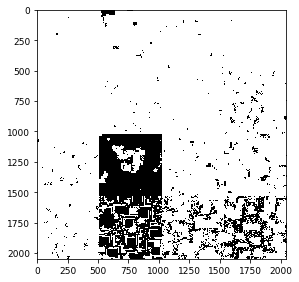

In [41]:
from skimage import data
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

import matplotlib
import matplotlib.pyplot as plt

from skimage import data, io, filters


# load image
# image = data.imread("C:/structure/data/blobs.tif")
#split channels
image = reconst_img

# threshold
threshold = filters.threshold_otsu(image)
print(threshold)
thresholded = image >= threshold

# show result
io.imshow(thresholded)
io.show()

-----------------------------------------------------------
Running prediction on image:   Medellin_40cm.tif


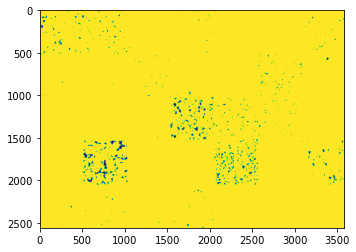

In [29]:
# path_to_dir = str(cfg.infer_data_tif_path) # '/home/root/tests/resources/infer_data_tif' # infer_data_tif

path_to_dir = '/home/root/tests/resources/train_data_tif/rasters/'
image_name = 'Medellin_40cm.tif'
# for image_name in tif_files:
print('-----------------------------------------------------------')
print("Running prediction on image:  ", image_name)
# specify the repository where the input file is located and its name
# path_to_dir = '/home/root/data/volumes/datasets/baranquilla_full_40cm/' # baranquilla_merged_33_resampled_40cm
path_to_file_complete = os.path.join(path_to_dir, image_name)
# print("----------------------------------------------------------------------------------------------------")
# print(path_to_file_complete)
img = imageio.imread(path_to_file_complete)
# plt.imshow(img)
# patches = extract_patches(img)
# print(patches.shape)
# print(patches.reshape((-1, 1024, 1024, 3)).shape)
image_size = img.shape
# print("image size :", image_size)
input_patch_size = (512, 512, 3)
padded_image_size = [math.ceil(image_size[i]/input_patch_size[i]) * (input_patch_size[i]) for i in range(3)]
# print("padded image size :", padded_image_size)
topad = []
for i in range(len(image_size)-1):
    if (padded_image_size[i] - image_size[i])%2 == 0:
        topad.append((int((padded_image_size[i]- image_size[i])/2), int((padded_image_size[i]- image_size[i])/2)))
    else:
        topad.append((int((padded_image_size[i]- image_size[i])//2), int((padded_image_size[i]- image_size[i])//2)+1))
topad.append((0,0))
# print(tuple(topad))
###
ret = np.pad(img, pad_width=tuple(topad), mode='reflect')
# print("Confirm new padded image size :", ret.shape)
###
# proceed to extract overlapping patches
ret_patches = extract_patches(ret, patch_shape=(512,512,3), extraction_step=512)
# print(ret_patches.shape)
# X = np.transpose(patches.reshape((-1, 32, 32, 3)), (0, 3, 1, 2))
# print(ret_patches.reshape((-1, 512, 512, 3)).shape)
# plt.imshow(ret)
# Extra padding step to account for patch overlap during prediction process
aug_img = np.pad(ret, pad_width=((256, 256), (256, 256), (0, 0)), mode='reflect')
# print("Check newly padded (augmented) image size :", aug_img.shape)
# plot augmented image
# plt.imshow(aug_img)
# proceed to extract overlapping patches
aug_patches = extract_patches(aug_img, patch_shape=(1024,1024,3), extraction_step=512)
topredict = aug_patches.reshape((-1, 1024, 1024, 3))
pred_aug_patches = []
for i in range(aug_patches.reshape((-1, 1024, 1024, 3)).shape[0]):
    pred_aug_patches.append(model(topredict[i,:,:,:][None, ...]/255.))
pred_aug_patchex = np.array(np.squeeze(pred_aug_patches))
(I,J,K) =  (ret.shape[0]//512, ret.shape[1]//512, 3)
reconst_img = np.empty((ret.shape[0],ret.shape[1]), float)
index = 0
for i in range(I):
    # print('j : ', j)
    for j in range(J):
        # print('i : ', i)
        reconst_img[512*i:512*(i+1), 512*j:512*(j+1)] = pred_aug_patchex[index,256:1024-256,256:1024-256] # aug_patches.reshape((-1, 640, 640, 3))[index,64:640-64,64:640-64,:]
        index += 1
    #
#
# print()
# print(reconst_img.shape)
plt.imshow(reconst_img)
reconst_img_origin = reconst_img[topad[0][0]:reconst_img.shape[0]-topad[0][1],topad[1][0]:reconst_img.shape[1]-topad[1][1]]
###
# np.save('predImg_output_xyz.npy', reconst_img_origin)
###
datenow = time.strftime("%Y%m%d-%H%M%S")
# output_name = "Model_Segmentalist_infer_" + image_name + "_" + datenow + ".tif" # 'predictedImgOutput.tif'
# output_path = cfg.predictions_data_tif_path / Path(output_name)
# #     with rasterio.open(path_to_file_complete) as src:
# #         profile = src.profile
# #         profile.update(count=1)
# #         with rasterio.open(output_path, 'w', **profile) as dst:
# #             #
# #             dst.write(tf.cast(reconst_img_origin*255., tf.uint8), indexes=1)

In [31]:
df_trained_models = utils.collate_run_data(Path(str(cfg.models_path)), model_name="Segmentalist")
df_sorted = df_trained_models.sort_values(by='lowest_val_loss').query(
    f'datasets == "{args.training_datasets}" and loss_fn == "{args.loss_fn}"'
)
best_row = df_sorted.iloc[0]
model = Segmentalist.load_from_metadata(best_row)

/home/root/saved_models/Segmentalist_fe08070b-16d8-4a4d-86ec-2e159e4e0fb6 failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_524faef9-1cdf-4f4d-a307-1314faf0cf43 failed with exception:
'NoneType' object has no attribute 'group'


AttributeError: 'dict' object has no attribute 'training_datasets'

In [96]:
project_name=Path(f'Segmentalist_{uuid.uuid4()}')
project_name 

PosixPath('Segmentalist_bd2e4276-fd3a-410c-aa4b-393da8423418')

In [35]:
checkpoint_dir = '/home/root/saved_models/Segmentalist_92097dcb-0801-4653-9388-5fefe8093cac/'
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

checkpoint_path = latest

'/home/root/saved_models/Segmentalist_92097dcb-0801-4653-9388-5fefe8093cac/cp-e03-ji1.52074-l-0.20076-vl0.00.ckpt'

In [37]:
# Save the weights
model.save_weights('my_checkpoint')

In [41]:
# model.save('my_model.h5')

model.save('mymodel')

KeyError: 'self'

In [ ]:
# checkpoint_path = "/home/root/saved_models/Segmentalist_3b57e05b-c523-4669-ae87-808695235f73/cp-e06-ji1.52000-l-0.20043-vl0.00.ckpt"
# checkpoint_dir = '/home/root/saved_models/Segmentalist_3b57e05b-c523-4669-ae87-808695235f73/'

In [ ]:
# os.listdir(checkpoint_dir)
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest

# # Load the lastest saved weights
# model.load_weights(latest)

In [39]:
# Save the weights
# model.save_weights('my_checkpoint')
utils.collate_run_data??

In [ ]:
df_segm_trained = utils.collate_run_data(Path(str(cfg.models_path)), model_name='Segmentalist')
df_segm_trained
# 
df_segm_trained = df_segm_trained.drop(['seed', 'save_to_cache'] + [c for c in df_segm_trained.columns if any(i in c for i in ('_train',  'ocp', 'fancy_augs', 'dump_test_data', 'dump_first_batches', 'channel_expansion_factor'))], axis=1).sort_values(by='lowest_loss')
# we can select a sub
view_cols = ['datasets', 'lowest_loss', 'balanced_oversample', 'batch_size', 'patch_size', 'overlapping_tiles', 'deep_supervision', 'target_spatial_resolution', 'pyramid_pooling', 'loss_fn', 'val_frac']
# 
df_segm_trained[view_cols + ['uuid4'] ] # 
row = df_segm_trained.query('datasets == "des_ds"').iloc[0]
# row
inference_window_size = 1024
# load again with new patch shape
# model = Segmentalist.load_from_metadata(row=row)
# # shouldn't have to run these lines, LRM will look at the method above and fix so weight loading is included properly...
# # workaround which fixes weight loading; "prime" model on something of the right shape
# model(np.random.rand(1, inference_window_size, inference_window_size, 3))
# model.load_weights(row.lowest_loss_ckpt) # takes a wee minute
# model.stop_training = True

In [93]:
utils.collate_run_data??

In [49]:
Path(str(cfg.models_path))

PosixPath('/home/root/saved_models')

In [66]:
import pandas as pd
def collate_run_data(                                                                  
    models_dir,                                                                        
    model_name='DeepResUNet',                                                          
    dataset_aliases=None                                                               
):                                                                                     
    """                                                                                
    Creates a dataframe containing metadata on all trained models in a directory       
                                                                                       
    model_name can be a regex                                                          
    """                                                                                
    runs = []                                                                          
    for m in glob(f'{model_dir1}{model_name}_*'):                                     
        if re.match(f'{model_name}''_(\w+-){,4}\w+$',str(m[0])):                
            trhttp://127.0.0.1:8888/notebooks/notebooks/max/gim_cv_max_modified.ipynb#y:                                                                       
                runs.append(get_run_data(m, dataset_aliases=dataset_aliases))          
            except Exception as e:                                                     
                print(f"{m} failed with exception:")                                   
                print(e)                                                               
    return pd.concat(runs, axis=1).T

In [97]:
models_dir1 = Path(str(cfg.models_path))
models_dir1.glob(f'{model_name}_*')

# collate_run_data(Path(str(cfg.models_path)), model_name="Segmentalist")

<generator object Path.glob at 0x7f5dbaa11900>

In [84]:
from pathlib import Path
model_dir1 = '/home/root/saved_models/'
folder_path = Path(model_dir1)
folder_path.glob(f'{model_name}_*')

<generator object Path.glob at 0x7f5ded760890>

In [102]:
uuid4_ = re.match('.*_(?P<uuid4>(\w+-){,4}\w+)$', str(folder_path.parts[-1])).group('uuid4')
uuid4_

'models'

In [92]:
dataset_aliases = None
runs = []
for m in folder_path.glob(f'{model_name}_*'):
#     print (m)
# for m in models_dir.glob(f'{model_name}_*'):
    if re.match(f'{model_name}''_(\w+-){,4}\w+$',str(m.parts[-1])):
        try:
            runs.append(get_run_data(m, dataset_aliases=dataset_aliases))
        except Exception as e:
            print(f"{m} failed with exception:")
            print(e)
if not runs:
    raise Exception(f"No model directories found at {folder_path}!")
return pd.concat(runs, axis=1).T

/home/root/saved_models/Segmentalist_92097dcb-0801-4653-9388-5fefe8093cac failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_17159bab-86a6-465b-9b2f-af72ad188fac failed with exception:
[Errno 2] No such file or directory: '/home/root/saved_models/Segmentalist_17159bab-86a6-465b-9b2f-af72ad188fac/run_params.yml'
/home/root/saved_models/Segmentalist_bcdf2b37-2e0b-4554-ba37-8bd8714fad0a failed with exception:
could not determine a constructor for the tag 'tag:yaml.org,2002:python/tuple'
  in "/home/root/saved_models/Segmentalist_bcdf2b37-2e0b-4554-ba37-8bd8714fad0a/run_params.yml", line 17, column 20
/home/root/saved_models/Segmentalist_24b6bc38-9a82-4b03-a43d-93563c38829c failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_1f713f04-1605-4ce4-8aad-f0acd70cfc38 failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_925bc711-0111-4867-89fd-bf

Exception: No model directories found at /home/root/saved_models!

In [81]:
cfg.models_path??

In [95]:
df_trained_models = utils.collate_run_data(Path(str(cfg.models_path)), model_name="Segmentalist")
df_trained_models
# df_sorted = df_trained_models.sort_values(by='lowest_val_loss').query(
#     f'datasets == "{args.training_datasets}" and loss_fn == "{args.loss_fn}"')

/home/root/saved_models/Segmentalist_92097dcb-0801-4653-9388-5fefe8093cac failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_17159bab-86a6-465b-9b2f-af72ad188fac failed with exception:
[Errno 2] No such file or directory: '/home/root/saved_models/Segmentalist_17159bab-86a6-465b-9b2f-af72ad188fac/run_params.yml'
/home/root/saved_models/Segmentalist_24b6bc38-9a82-4b03-a43d-93563c38829c failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_1f713f04-1605-4ce4-8aad-f0acd70cfc38 failed with exception:
'NoneType' object has no attribute 'group'
/home/root/saved_models/Segmentalist_9ac738b2-8bf2-4d17-9c9f-5c77fa330588 failed with exception:
[Errno 2] No such file or directory: '/home/root/saved_models/Segmentalist_9ac738b2-8bf2-4d17-9c9f-5c77fa330588/run_params.yml'
/home/root/saved_models/Segmentalist_3b57e05b-c523-4669-ae87-808695235f73 failed with exception:
'NoneType' object has no attribut

,uuid4,training_dir,lowest_loss_ckpt,lowest_val_loss_ckpt,lowest_loss,lowest_val_loss,X0_train,y0_train,X0_val,y0_val,...,residual_filters_,sag,save_to_cache,seed,swa,target_spatial_resolution,test_frac,use_cache,use_val,val_frac
0,bcdf2b37-2e0b-4554-ba37-8bd8714fad0a,/home/root/saved_models/Segmentalist_bcdf2b37-...,/home/root/saved_models/Segmentalist_bcdf2b37-...,/home/root/saved_models/Segmentalist_bcdf2b37-...,0.52538,0.0,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1
1,925bc711-0111-4867-89fd-bf5258fc0a55,/home/root/saved_models/Segmentalist_925bc711-...,None,None,NaN,NaN,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.6,0.0,False,False,0.1
2,54a6e24f-9efd-4280-a5eb-7dbf96c2f394,/home/root/saved_models/Segmentalist_54a6e24f-...,/home/root/saved_models/Segmentalist_54a6e24f-...,/home/root/saved_models/Segmentalist_54a6e24f-...,0.31589,0.0,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1
3,d75295fb-5cf4-4f2b-a989-d9f67f608c03,/home/root/saved_models/Segmentalist_d75295fb-...,/home/root/saved_models/Segmentalist_d75295fb-...,/home/root/saved_models/Segmentalist_d75295fb-...,0.32132,0.0,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1
4,792be1c1-f498-441d-b522-285d713b63bf,/home/root/saved_models/Segmentalist_792be1c1-...,/home/root/saved_models/Segmentalist_792be1c1-...,/home/root/saved_models/Segmentalist_792be1c1-...,0.27234,0.0,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.5,0.0,False,False,0.1
5,50bfcbc9-f4ed-4b94-8bb6-65c8e8ae44c8,/home/root/saved_models/Segmentalist_50bfcbc9-...,/home/root/saved_models/Segmentalist_50bfcbc9-...,/home/root/saved_models/Segmentalist_50bfcbc9-...,0.35915,0.0,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.6,0.0,False,False,0.1
6,64bee077-628b-420f-b066-bb1983f75c60,/home/root/saved_models/Segmentalist_64bee077-...,None,None,NaN,NaN,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1
7,ff5c289d-3422-42b6-a615-2e7efb5c71a0,/home/root/saved_models/Segmentalist_ff5c289d-...,None,None,NaN,NaN,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1
8,8a601d7c-ce9e-4ee9-8cb7-82b7803491c5,/home/root/saved_models/Segmentalist_8a601d7c-...,None,None,NaN,NaN,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1
9,5bf57efd-d775-48f6-86f7-de6ec5d3622b,/home/root/saved_models/Segmentalist_5bf57efd-...,None,None,NaN,NaN,None,None,None,None,...,"[128, 256, 512, 1024]",True,False,42,True,0.4,0.0,False,False,0.1


In [41]:
gim_cv.training.get_run_data??

Object `gim_cv.training.get_run_data` not found.


In [15]:
from gim_cv.training import get_run_data

In [16]:
get_run_data??

In [60]:
from glob import glob

model_dir1 = '/home/root/saved_models/'
# model_dir1 = re.compile (model_dir1)
model_name = 'Segmentalist'
alist =  glob('/home/root/saved_models/*')

for m in glob(f'{model_dir1}{model_name}_*'):
    re.match(f'{model_name}''_(\w+-){,4}\w+$',str(m.parts[-1])): 
        print (0)

SyntaxError: invalid syntax (<ipython-input-60-f75660a912aa>, line 9)

In [58]:
print(f'{model_dir1}{model_name}_*')

re.compile('/home/root/saved_models/')Segmentalist_*


In [ ]:
df_train = get_run_data(checkpoint_dir)

In [47]:
from glob import glob

model_dir1 = '/home/root/saved_models/Segmentalist_92097dcb-0801-4653-9388-5fefe8093cac'
print(os.listdir(model_dir1))
cp_ptn:str=(
    'cp-e(?P<epoch>\d+)(-ji(?P<ji>[\d.]+))?-l(?P<loss>[\d.]+)'
    '-vl(?P<val_loss>[\d.]+).ckpt.index'
    )
uuid4_ = re.match('.*_(?P<uuid4>(\w+-){,4}\w+)$', str(model_dir1.parts[-1])).group('uuid4')
ckpts = glob(model_dir1+'*.ckpt.index')
base_paths, losses, val_losses, epochs = [], [], [], []
for ckpt in ckpts:
    base_paths.append(str(ckpt)[:-6]) # remove index
    cp_match = re.match(
        cp_ptn,
        str(ckpt.parts[-1])
    )
    epochs.append(cp_match.group('epoch'))
    losses.append(cp_match.group('loss'))
    val_losses.append(cp_match.group('val_loss'))
best_trn_loss_ix = np.argmin(losses) if losses else 0
best_val_loss_ix = np.argmin(val_losses) if val_losses else 0
try:
    low_l_cp = base_paths[best_trn_loss_ix]
    low_l = losses[best_trn_loss_ix]
except IndexError:
    low_l_cp = None
    low_l = None
try:
    low_vl_cp = base_paths[best_val_loss_ix]
    low_vl = losses[best_val_loss_ix]
except IndexError:
    low_vl_cp = None
    low_vl = None
try:
    X0_train = list(glob(model_dir1+'X_train*.npy'))[0]
    y0_train = list(glob(model_dir1+'y_train*.npy'))[0]
except IndexError:
    X0_train = None
    y0_train = None
try:
    X0_val = list(glob(model_dir1+'X_val*.npy'))[0]
    y0_val = list(glob(model_dir1+'y_val*.npy'))[0]
except IndexError:
    X0_val = None
    y0_val = None
metadata = {
    'uuid4' : uuid4_,
    'training_dir' : str(model_dir1),
    'lowest_loss_ckpt' : low_l_cp,
    'lowest_val_loss_ckpt' : low_vl_cp,
    'lowest_loss' : np.float32(low_l),
    'lowest_val_loss' : np.float32(low_vl),
    'X0_train' : X0_train,
    'y0_train' : y0_train,
    'X0_val' : X0_val,
    'y0_val' : y0_val
}
with open(model_dir1 / Path('run_params.yml')) as f:
    params = yaml.load(f, Loader=yaml.SafeLoader)
metadata.update(params)
if dataset_aliases:
    metadata['datasets_alias'] = dataset_aliases.get(metadata['datasets'], metadata['datasets'])
pd.Series(metadata)

['run_params.yml', 'cp-e01-ji1.48150-l-0.18398-vl0.00.ckpt.data-00001-of-00002', 'cp-e02-ji1.50929-l-0.19593-vl0.00.ckpt.index', 'cp-e03-ji1.52074-l-0.20076-vl0.00.ckpt.data-00001-of-00002', 'checkpoint', 'cp-e03-ji1.52074-l-0.20076-vl0.00.ckpt.data-00000-of-00002', 'transform.yml', 'cp-e03-ji1.52074-l-0.20076-vl0.00.ckpt.index', 'cp-e01-ji1.48150-l-0.18398-vl0.00.ckpt.index', 'cp-e01-ji1.48150-l-0.18398-vl0.00.ckpt.data-00000-of-00002', 'metrics', 'cp-e02-ji1.50929-l-0.19593-vl0.00.ckpt.data-00000-of-00002', 'cp-e02-ji1.50929-l-0.19593-vl0.00.ckpt.data-00001-of-00002']


ConstructorError: could not determine a constructor for the tag 'tag:yaml.org,2002:python/tuple'
  in "/home/root/saved_models/Segmentalist_92097dcb-0801-4653-9388-5fefe8093cac/run_params.yml", line 17, column 20

In [ ]:
from glob import glob
ckpts = glob(checkpoint_dir+'*.ckpt.index')
ckpts

AttributeError: 'str' object has no attribute 'parts'

In [28]:
get_run_data(
    model_dir=model_dir1,
    cp_ptn= 'cp-e(?P<epoch>\\d+)(-ji(?P<ji>[\\d.]+))?-l(?P<loss>[\\d.]+)-vl(?P<val_loss>[\\d.]+).ckpt.index',
    dataset_aliases=None,
)

AttributeError: 'str' object has no attribute 'parts'

In [33]:
os.listdir(checkpoint_dir)
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

# Load the lastest saved weights
row1 = model.load_weights(latest)
row1

In [34]:
inference_window_size = 1024

# load again with new patch shape
model = Segmentalist.load_from_metadata(row=row1)
# shouldn't have to run these lines, LRM will look at the method above and fix so weight loading is included properly...
# workaround which fixes weight loading; "prime" model on something of the right shape
model(np.random.rand(1, inference_window_size, inference_window_size, 3))
model.load_weights(row.lowest_loss_ckpt) # takes a wee minute
model.stop_training = True

AttributeError: 'CheckpointLoadStatus' object has no attribute 'sag'